In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn import metrics

from sqlalchemy import create_engine
import datetime 
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib
from TurbineTimeSeries.storage import MachineDataStore
#from TurbineTimeSeries.transformations import PCA, StandardScaler, DropCols, DropSparseCols, LeftJoin

In [2]:
model_number = 2

store = MachineDataStore('.config')

model_data_hr = (store.query(model_number,'1hr')
                 .not_null(['timestamp','psn'])
                 .exclude_psn([44,52,54,70])
                 .execute())

model_data_min = (store.query(model_number,'10min')
                  .not_null(['timestamp','psn'])
                  .exclude_psn([44,52,54,70])
                  .execute())

model_data_min.head()

,id,lo_c_dp1,f_c_dp1,f_c_dp2,f_c_dp5,pe_c_dt1,g_c_dt1,g_c_dt2,lo_c_dt5,c_dt5_1,...,v_d_2b,lo_t5,g_t2,f_t1,sum_enr,g_t3,g_pct1,f_pos1,timestamp,psn
0,1,0.378187,0.337323,-0.181580,0.283768,0.546667,0.352,0.398,0.444706,-0.021556,...,0.167029,0.714348,0.836571,0.3800,22452.305823,0.8516,0.10789,0.213541,2017-06-26 12:00:11.999995,39
1,2,0.384455,0.304681,-0.062424,0.281090,0.578889,0.360,0.374,0.443529,-0.019334,...,0.170886,0.713913,0.829714,0.3775,22452.415190,0.8472,0.11142,0.216346,2017-06-26 12:10:00.000004,39
2,3,0.395580,0.256122,0.017021,0.284209,0.567778,0.366,0.398,0.444706,-0.022222,...,0.162286,0.713043,0.834857,0.3770,22452.642025,0.8476,0.11171,0.214744,2017-06-26 12:30:00.000003,39
3,4,0.388409,0.268359,-0.073769,0.282309,0.564444,0.352,0.372,0.447059,-0.019722,...,0.161743,0.713043,0.826286,0.3750,22452.753418,0.8620,0.10986,0.214342,2017-06-26 12:39:59.999997,39
4,5,0.385170,0.269397,-0.175926,0.281459,0.567778,0.324,0.380,0.447059,-0.020722,...,0.165914,0.713913,0.829714,0.3760,22452.866835,0.8788,0.10974,0.215144,2017-06-26 12:50:00.000002,39


In [3]:
freq = '10min'
model_data = model_data_min
len(model_data)

1602740

In [6]:
skipped_cols = ['sum_esn','sum_eng_st', 'sum_eng_h']
index_cols = ['id','timestamp','psn']
data_cols = [c for c in model_data.columns if (c not in index_cols) and (c not in skipped_cols)]

In [7]:
missing_values = model_data.isnull().sum().sort_values()
sparse_cols = [x for x in missing_values.index if missing_values[x] > 30000]
clean_data_cols = [x for x in data_cols if x not in sparse_cols]

In [8]:
data = model_data[index_cols + clean_data_cols].dropna().reset_index()
clean_data = StandardScaler().fit_transform(data[clean_data_cols])

pca =  PCA().fit(clean_data)
reduced = pca.transform(clean_data)

In [9]:
def roundTime(dt=None, roundTo=60):
    """Round a datetime object to any time laps in seconds
    dt : datetime.datetime object, default now.
    roundTo : Closest number of seconds to round to, default 1 minute.
    Author: Thierry Husson 2012 - Use it as you want but don't blame me.
    """
    if dt == None : dt = datetime.datetime.now()
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)
n = datetime.datetime(2015,12,5,0,10,0,4)
print(n)
print(roundTime(n,600))

2015-12-05 00:10:00.000004
2015-12-05 00:10:00


In [12]:
eigenvectors_to_segment = 1
hour_segments = []

def hour_group(x):
    return str(x['iso'][0])+'-'+str(x['iso'][1])+'-'+str(x['iso'][2])+'-'+str(x['hour'])

for i in range(eigenvectors_to_segment):
    hour_segments.append([])
    
for psn in data['psn'].sort_values().unique():
    print(str(psn), datetime.datetime.now())
    psn_data = pd.DataFrame(data[(data['psn'] == psn)])
    psn_data['timestamp'] = psn_data['timestamp'].apply(lambda x: roundTime(datetime.datetime(x.year,x.month,x.day,x.hour,x.minute,x.second),600))
    psn_data['iso'] = psn_data['timestamp'].apply(lambda x: x.isocalendar())
    psn_data['hour'] = psn_data['timestamp'].apply(lambda x: x.time().hour)
    psn_data['minute'] = psn_data['timestamp'].apply(lambda x: x.time().minute)
    print('\t time parsing done', datetime.datetime.now())
    psn_data['hour_group'] = psn_data.apply(hour_group,1)
    complete_groups = (psn_data.groupby(by=['hour_group']).count()['id'] == 6)
    psn_data['complete_group'] = psn_data['hour_group'].apply(lambda x: complete_groups[x])
    psn_data = psn_data[psn_data['complete_group'] == True]
    print('\t block grouping done', datetime.datetime.now())
   
    for d in psn_data['hour_group'].unique():
        group_data = (psn_data[psn_data['hour_group'] == d]).sort_values(by='minute')
        idx = group_data.index
        
        for i in range(eigenvectors_to_segment):
            hour_segments[i].append([x for x in reduced[idx,i]])
    
    print('\t block aggregating done', datetime.datetime.now())
   
 

34 2018-04-26 18:22:10.208589
	 time parsing done 2018-04-26 18:22:12.147984
	 block grouping done 2018-04-26 18:22:24.487969
	 block aggregating done 2018-04-26 18:25:23.405948
35 2018-04-26 18:25:23.406951
	 time parsing done 2018-04-26 18:25:24.749821
	 block grouping done 2018-04-26 18:25:33.156955
	 block aggregating done 2018-04-26 18:26:56.663761
36 2018-04-26 18:26:56.664737
	 time parsing done 2018-04-26 18:26:57.963746
	 block grouping done 2018-04-26 18:27:06.313767
	 block aggregating done 2018-04-26 18:28:31.014883
37 2018-04-26 18:28:31.015887
	 time parsing done 2018-04-26 18:28:32.314786
	 block grouping done 2018-04-26 18:28:39.281908
	 block aggregating done 2018-04-26 18:30:01.211681
38 2018-04-26 18:30:01.212183
	 time parsing done 2018-04-26 18:30:01.982791
	 block grouping done 2018-04-26 18:30:05.565663
	 block aggregating done 2018-04-26 18:30:28.965096
39 2018-04-26 18:30:28.965096
	 time parsing done 2018-04-26 18:30:29.391197
	 block grouping done 2018-04-26 

In [15]:
def plot_cluster_distribution():
    plt.rcParams["figure.figsize"] = (15,15)
    fig = plt.figure(0)
    ax1 = plt.subplot2grid((1,1), (0, 0))
    ax1.bar(range(225),label_counts[:])
    ax1.set_ylabel('Segment Count')
    ax1.set_xlabel('Cluster')
    plt.suptitle("Model {} Cluster Distributions for Eigenvector {}, 60 Minute Profiles".format(model_number, j+1))
    plt.grid("on")
    fig.savefig("model{}_kmeans_{}_eig{}_60_min_cluster_distribution.png".format(model_number, n_clusters,j+1))
       
    plt.show()
    
def plot_cluster_grid():
    plt.rcParams["figure.figsize"] = (15,15)
    plt.show()

    grid_size = (n_clusters,1)
    cluster_means = []

    fig = plt.figure(0)
    row = -1
    shared_ax = None

    for i,c in enumerate(labels_sorted_by_freq):
        cluster_data = [to_be_clustered[j] for j in range(len(cluster.labels_)) if cluster.labels_[j] == c]
        cluster_means.append(pd.DataFrame(cluster_data).mean())
        
        col = i%15
        row = row if col > 0 else row+1
        
        ax = plt.subplot2grid((15,15), (row,col),sharey=shared_ax)
        
        ax.plot(pd.DataFrame(cluster_data).T,alpha=0.2, color='red')
        plt.axis('off')
        
        if shared_ax is None:
            shared_ax = ax     

        
    plt.suptitle("Model {} Eigenvector {}, 60 Minute Profiles".format(model_number, j+1))  
    fig.savefig("model{}_kmeans_{}_eig{}_60_min_cluster_grid.png".format(model_number, n_clusters,j+1))
    plt.close()
    
def plot_clusters(c_idx):
    plt.rcParams["figure.figsize"] = (14, 7)
    for i, c in enumerate(c_idx):
        cluster_data = [to_be_clustered[j] for j in range(len(cluster.labels_)) if cluster.labels_[j] == c]
                
        fig = plt.figure(0)
        ax = plt.subplot2grid((1,1), (0,0))
        ax.plot(pd.DataFrame(cluster_data).T,alpha=0.2, color='red')
        ax.set_xlabel('Time of Day')
        plt.suptitle("Model {} Eigenvector {}, 60 Minute Cluster {} ".format(model_number, j+1, i+1))  
        fig.savefig("model{}_kmeans_{}_eig{}_60_min_cluster{}.png".format(model_number, n_clusters,j+1, i+1))
        plt.close()
      

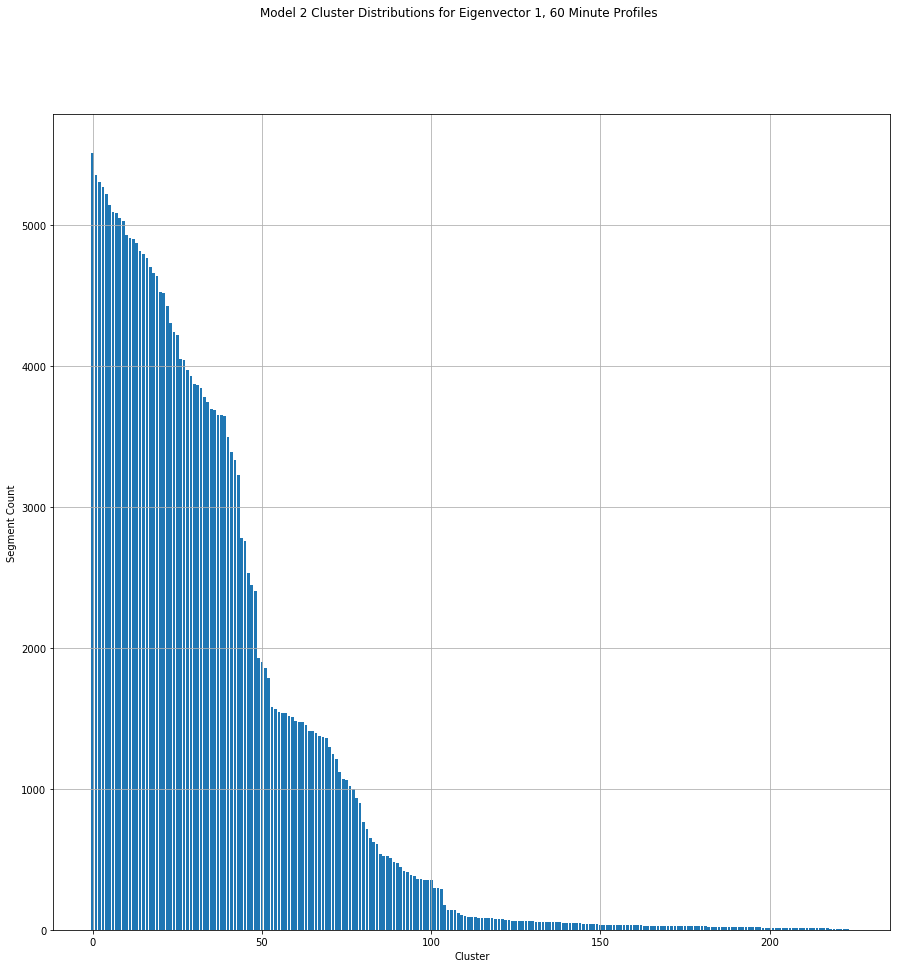

In [17]:
for j, daily_coefficients in enumerate(hour_segments):
    to_be_clustered = daily_coefficients
    n_clusters=225

    cluster = KMeans(n_clusters)
    cluster.fit(to_be_clustered)
    label_df = pd.DataFrame(cluster.labels_)
    label_counts = label_df[0].value_counts().sort_values(ascending=False)
    labels_sorted_by_freq = list(label_counts.keys())
    
    plot_cluster_distribution()
    plot_cluster_grid()
    if j == 0:
        plot_clusters(labels_sorted_by_freq)